<a href="https://colab.research.google.com/github/Capstone-Team-CH2-PS379/Machine-Learning/blob/main/model-experiments/Speech_Recognition_Model_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
import pathlib
import librosa
import seaborn as sns
from IPython import display
from urllib.request import urlopen
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

# Download and Unzip Data

In [2]:
import requests
import tarfile
from io import BytesIO

# Dataset URL
url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'

# Get file content from URL
response = requests.get(url)

# Extracting file using tarfile
with tarfile.open(fileobj=BytesIO(response.content), mode="r:bz2") as tar:
    extraction_path = 'Dataset'
    tar.extractall(extraction_path)

print("Data is already downloaded and extracted at", extraction_path)


Data is already downloaded and extracted at Dataset


In [3]:
# Paths
dataset_path = "Dataset/LJSpeech-1.1"
metadata_path = dataset_path + "/metadata.csv"
wavs_path = dataset_path + "/wavs/"

# Data Pre-processing

In [4]:
def get_waveform_and_label(file_path):
    # Read audio file
    audio_binary = tf.io.read_file(file_path)

    # Decode audio as float32 wave
    waveform, _ = tf.audio.decode_wav(audio_binary)

    # Get label from file path
    label = tf.strings.split(file_path, os.path.sep)[-1]

    return waveform, label

In [5]:
file_paths = tf.data.Dataset.list_files(wavs_path + "*.wav")

# Create dataset by mapping get_waveform_and_label function
waveform_dataset = file_paths.map(get_waveform_and_label)

In [6]:
# Plotting waveforms
def plot_waveforms(waveforms):
    plt.figure(figsize=(10, 6))
    for i, (waveform, label) in enumerate(waveforms.take(3)):
        plt.subplot(3, 1, i + 1)
        plt.plot(waveform.numpy())
        plt.title(label.numpy().decode("utf-8"))
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

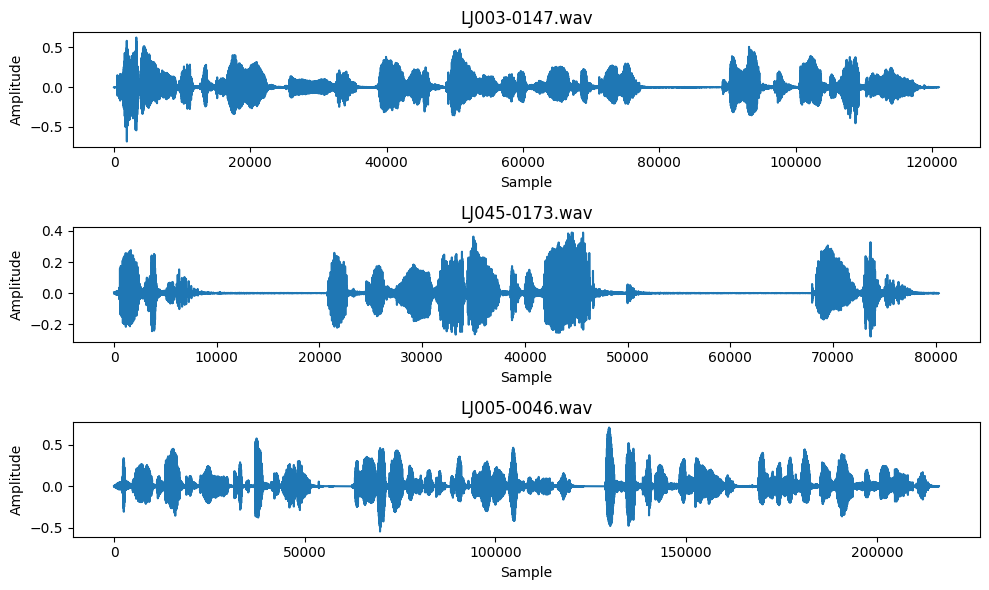

In [7]:
# Show some waveforms plot
plot_waveforms(waveform_dataset)

In [11]:
# Function to convert waveform to spectrogram

def get_spectrogram(waveform, frame_length=255, frame_step=128):
    # Remove the extra dimension
    waveform = tf.squeeze(waveform, axis=-1)

    # Zero-padding for an audio waveform with less than frame_length samples.
    input_len = frame_length
    waveform_len = tf.shape(waveform)[0]

    # If waveformlength is shorter than frame_length, do zero-padding
    padding_len = tf.maximum(0, input_len - waveform_len)
    waveform = tf.pad(waveform, paddings=[[0, padding_len]], constant_values=0.0)

    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)

    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=frame_length, frame_step=frame_step)

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [12]:
# Take one example from dataset
example_waveform, example_label = next(iter(waveform_dataset))
example_spectrogram = get_spectrogram(example_waveform)

# Print the waveform tensor shape of the example
print("Waveform Tensor Shape:", example_waveform.shape)

# Print the spectrogram tensor shape of the example
print("Spectrogram Tensor Shape:", example_spectrogram.shape)

Waveform Tensor Shape: (98717, 1)
Spectrogram Tensor Shape: (770, 129, 1)


In [13]:
from IPython.display import Audio

# Convert the tensor to a NumPy array
audio_array = example_waveform.numpy().flatten()

# Play the audio
Audio(audio_array, rate=16000)

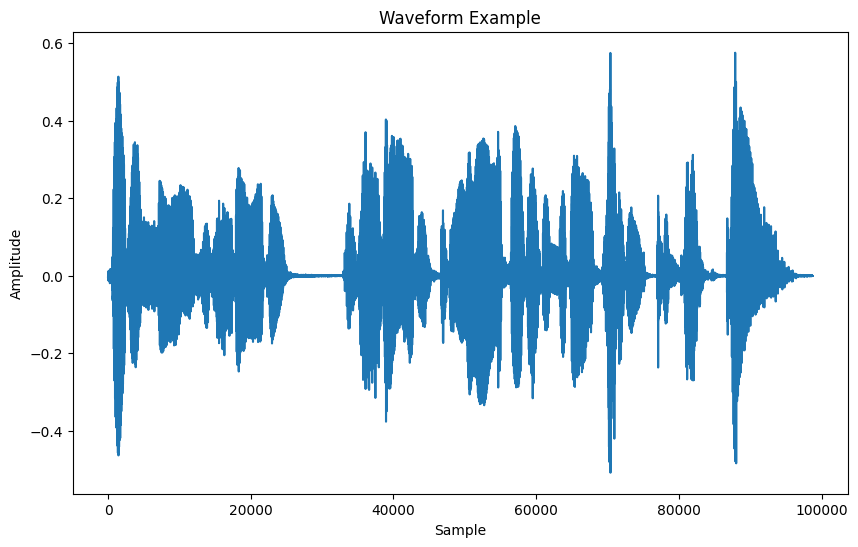

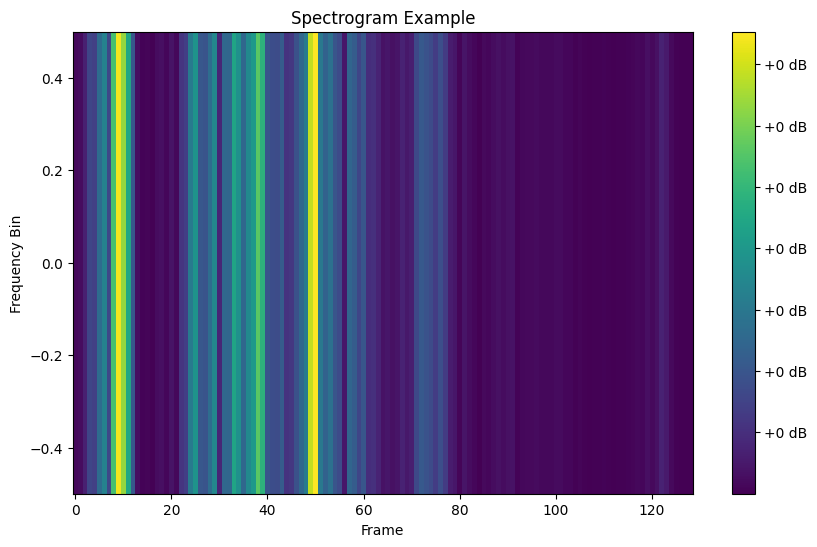

In [14]:
# Plot the waveform
plt.figure(figsize=(10, 6))
plt.plot(example_waveform.numpy())
plt.title("Waveform Example")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(example_spectrogram.numpy()[0].T), aspect="auto", origin="lower")
plt.title("Spectrogram Example")
plt.xlabel("Frame")
plt.ylabel("Frequency Bin")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [15]:
# Function to create spectrogram dataset
def waveform_to_spectrogram_dataset(waveform_dataset, frame_length=255, frame_step=128):
    spectrogram_dataset = waveform_dataset.map(
        lambda waveform, label: (get_spectrogram(waveform, frame_length, frame_step), label)
    )
    return spectrogram_dataset

In [16]:
# Creating spectrogram dataset
spectrogram_dataset = waveform_to_spectrogram_dataset(waveform_dataset)

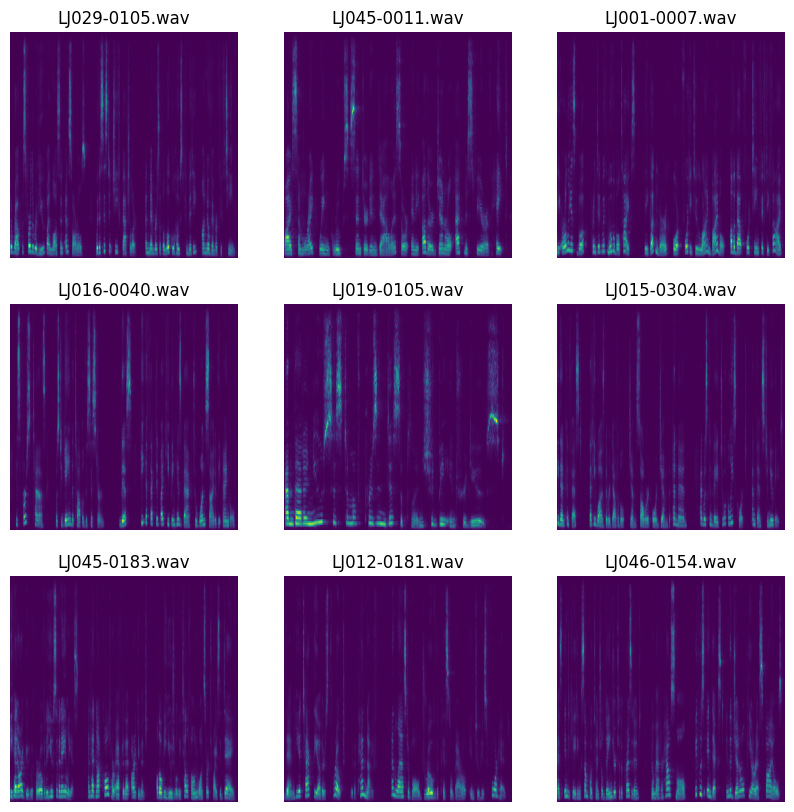

In [17]:
# Showing spectrograms from the dataset
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Iterate through the dataset and plot spectrograms
for i, (spectrogram, label) in enumerate(spectrogram_dataset.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r, c]
    ax.imshow(np.log1p(np.squeeze(spectrogram.numpy().T)), aspect="auto", origin="lower")
    ax.set_title(label.numpy().decode('utf-8'))
    ax.axis('off')

plt.show()

# Model Building and Training